In [32]:
import os
import numpy as np
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

# base_path 경로 설정
base_path = r"C:\Users\KOSA\Desktop\AUDIO_FEATURES"

# 파일 목록 가져오기
np_paths = os.listdir(base_path)

label1 = []
label0 = []

# 배치 크기 설정 (한 번에 처리할 데이터 수)
batch_size = 50

def process_batch(np_paths_batch):
    label1_batch = []
    label0_batch = []
    
    for np_path in tqdm(np_paths_batch):
        # 파일명에 'label_1' 또는 'label_accompaniment_1'이 포함된 경우만 처리
        if 'label_1' in np_path or 'label_accompaniment_1' in np_path:
            full_path = os.path.join(base_path, np_path)
            data = np.load(full_path)  # data는 (128, 157, 3) 크기의 배열

            # 리사이즈 과정 (128x157 -> 128x128)
            data_resized = cv2.resize(data, (128, 128)).astype(np.uint8)  # cv2로 128x128로 리사이즈하고 데이터 타입을 uint8로 변경

            # 각 레이블에 따라 리사이즈된 이미지 추가
            if np_path.split("_")[0] in ["낙상", "도움요청", "폭력범죄", "강도범죄"]:
                label1_batch.append(data_resized)
            elif np_path.split("_")[0] == "실내":
                label0_batch.append(data_resized)

    return label1_batch, label0_batch

# 전체 파일을 배치 단위로 나누어 처리
for i in range(0, len(np_paths), batch_size):
    np_paths_batch = np_paths[i:i + batch_size]
    
    # 배치 처리
    label1_batch, label0_batch = process_batch(np_paths_batch)
    
    # 결과를 전체 리스트에 추가
    label1.extend(label1_batch)
    label0.extend(label0_batch)

# 레이블 배열 결합
label1_resized = np.array(label1, dtype=np.uint8)  # 데이터 타입을 uint8로 지정하여 메모리 사용량 감소
label0_resized = np.array(label0, dtype=np.uint8)

# 배열 및 레이블 결합
X = np.concatenate([label1_resized, label0_resized], axis=0)
y = np.concatenate([np.ones(len(label1_resized)), np.zeros(len(label0_resized))], axis=0)

# train-test split 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 결과 확인
print("X_train shape:", X_train.shape)  # 예상: (n_train, 128, 128, 3)
print("X_test shape:", X_test.shape)    # 예상: (n_test, 128, 128, 3)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

100%|██████████| 4/4 [00:00<00:00, 275.35it/s]


X_train shape: (26796, 128, 128, 3)
X_test shape: (6699, 128, 128, 3)
y_train shape: (26796,)
y_test shape: (6699,)


In [ ]:

'''import os
import numpy as np
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

# base_path 경로 설정
base_path = r"C:\Users\KOSA\Desktop\AUDIO_FEATURES"

# 파일 목록 가져오기
np_paths = os.listdir(base_path)

label1 = []
label0 = []

# 파일을 순차적으로 탐색하면서 "낙상"으로 시작하는 파일 로드
for np_path in tqdm(np_paths[:]):
    full_path = os.path.join(base_path, np_path)
    data = np.load(full_path)  # data는 (128, 157, 3) 크기의 배열

    # 리사이즈 과정 (128x157 -> 128x128)
    data_resized = cv2.resize(data, (128, 128))  # cv2로 128x128로 리사이즈

    # 각 레이블에 따라 리사이즈된 이미지 추가
    if np_path.split("_")[0] in ["낙상", "도움요청", "폭력범죄", "강도범죄"]:
        label1.append(data_resized)
    elif np_path.split("_")[0] == "실내":
        label0.append(data_resized)
# label0=label1
# 레이블 배열 결합
label1_resized = np.array(label1)
label0_resized = np.array(label0)

# 배열 및 레이블 결합
X = np.concatenate([label1_resized, label0_resized], axis=0)
y = np.concatenate([np.ones(len(label1_resized)), np.zeros(len(label0_resized))], axis=0)

# train-test split 수행
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 결과 확인
print("X_train shape:", X_train.shape)  # 예상: (n_train, 128, 128, 3)
print("X_test shape:", X_test.shape)    # 예상: (n_test, 128, 128, 3)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
'''

100%|██████████| 128554/128554 [18:10<00:00, 117.87it/s]


MemoryError: Unable to allocate 23.0 GiB for an array with shape (125848, 128, 128, 3) and data type float32

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# X_train, Y_train 준비 (label1은 1, label0은 0으로 설정)
X_train = np.concatenate([label1, label0], axis=0)
y_train = np.concatenate([np.ones(len(label1)), np.zeros(len(label0))], axis=0)

# 레이블을 원-핫 인코딩
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)  # y_test도 원-핫 인코딩
# CNN 모델 정의
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # 2개의 클래스로 분류

# 모델 컴파일
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

Epoch 1/10
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 58s 55ms/step - accuracy: 0.9249 - loss: 17.5027 - val_accuracy: 0.9830 - val_loss: 0.0661
Epoch 2/10
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.9825 - loss: 0.0669 - val_accuracy: 0.9907 - val_loss: 0.0359
Epoch 3/10
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.9855 - loss: 0.0526 - val_accuracy: 0.9894 - val_loss: 0.0378
Epoch 4/10
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.9904 - loss: 0.0343 - val_accuracy: 0.9973 - val_loss: 0.0105
Epoch 5/10
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 106s 101ms/step - accuracy: 0.9915 - loss: 0.0296 - val_accuracy: 0.9952 - val_loss: 0.0190
Epoch 6/10
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 78s 75ms/step - accuracy: 0.9907 - loss: 0.0353 - val_accuracy: 0.9990 - val_loss: 0.0049
Epoch 7/10
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 58s 55ms/step - accuracy: 0.9924 - loss: 0.0270 - val_accuracy: 0.9987 - val_loss: 0.0064
Epoch 8/10
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 58s 56ms/step - accuracy: 0.993

In [34]:
model.save("jhyaudio2.h5")

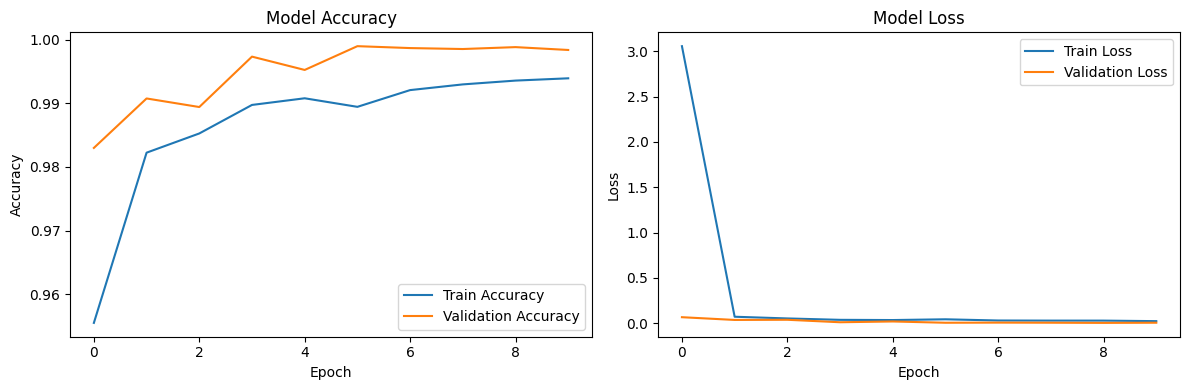

In [38]:
#jhyaudio2
import matplotlib.pyplot as plt

# 학습 정확도와 검증 정확도 시각화
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


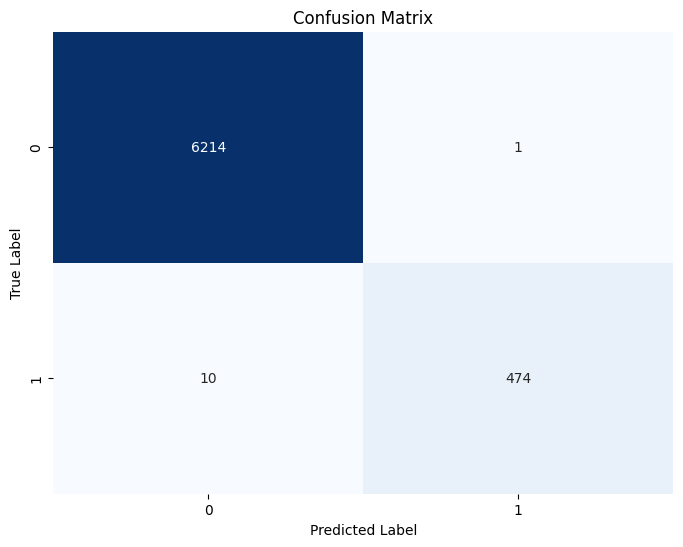

In [36]:
#jhyaudio2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 예측 수행
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스 (0 또는 1)
y_true = np.argmax(y_test, axis=1)  # 실제 클래스 (0 또는 1)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


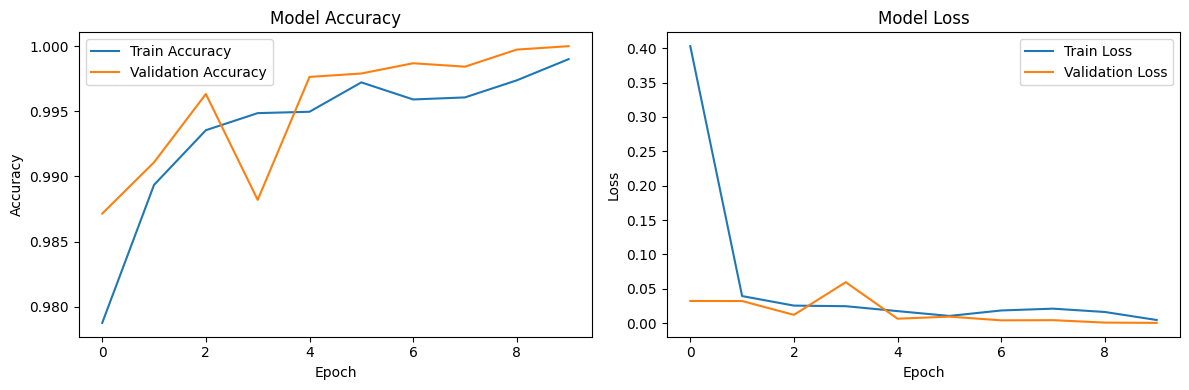

In [ ]:
'''
#jhyaudio1
import matplotlib.pyplot as plt

# 학습 정확도와 검증 정확도 시각화
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
'''

120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


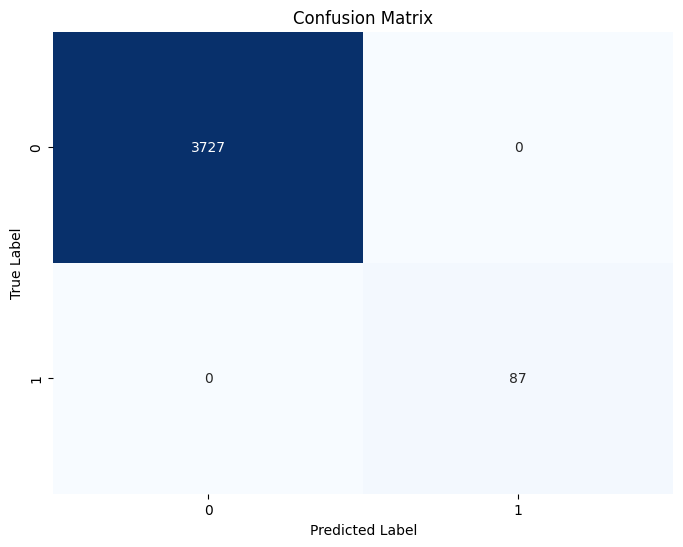

In [ ]:
'''
#jhyaudio1
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 예측 수행
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스 (0 또는 1)
y_true = np.argmax(y_test, axis=1)  # 실제 클래스 (0 또는 1)

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
'''
